In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout, concatenate

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3, 7"

### Dataset

In [5]:
dataset = pd.read_csv('../../data/pollution.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0


In [6]:
# data.tail(10)

### Dataset Information

In [7]:
print(list(data.columns))

['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']


### Pre-processing

In [8]:
# specify the number of lag hours
n_hours = 24*3
K = 24
n_features = data.shape[1]

#### Stage

In [9]:
# Pre-processing
# Stage --> 8 stages
pms = dataset[['pollution']]
print("pms.shape:", pms.shape)

# stages_supervised = stage_series_to_supervised(stages, n_hours, K, 1)
pms_supervised = series_to_supervised(pms, n_hours, K)
pms_supervised.reset_index(drop=True, inplace=True)
print("pms_supervised.shape:", pms_supervised.shape)

pms.shape: (43800, 1)
pms_supervised.shape: (43705, 96)


In [10]:
# pms_supervised

#### Prior known covariates (9)

In [11]:
# non_stages = data[['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'FLOW_S25B', 'GATE_S25B', 'FLOW_S26', 'GATE_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
prior_known_cov = data[['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']]
print("prior_known_cov.shape:", prior_known_cov.shape)

prior_known_cov_supervised = series_to_supervised(prior_known_cov, n_hours, K)
print("prior_known_cov_supervised.shape:", prior_known_cov_supervised.shape)

prior_known_cov.shape: (43800, 10)
prior_known_cov_supervised.shape: (43705, 960)


In [12]:
prior_known_cov_supervised.reset_index(drop=True, inplace=True)
prior_known_cov_supervised.columns = ['past_known_cov_' + i for i in list(prior_known_cov_supervised.columns)]

In [13]:
prior_known_cov_supervised

,past_known_cov_var1(t-72),past_known_cov_var2(t-72),past_known_cov_var3(t-72),past_known_cov_var4(t-72),past_known_cov_var5(t-72),past_known_cov_var6(t-72),past_known_cov_var7(t-72),past_known_cov_var8(t-72),past_known_cov_var9(t-72),past_known_cov_var10(t-72),...,past_known_cov_var1(t+23),past_known_cov_var2(t+23),past_known_cov_var3(t+23),past_known_cov_var4(t+23),past_known_cov_var5(t+23),past_known_cov_var6(t+23),past_known_cov_var7(t+23),past_known_cov_var8(t+23),past_known_cov_var9(t+23),past_known_cov_var10(t+23)
0,-16.0,-4.0,1020.0,1.79,0.0,0.0,0.0,0.0,1.0,0.0,...,-22.0,-16.0,1033.0,23.70,0.0,0.0,0.0,1.0,0.0,0.0
1,-15.0,-4.0,1020.0,2.68,0.0,0.0,0.0,0.0,1.0,0.0,...,-25.0,-17.0,1033.0,26.83,0.0,0.0,0.0,1.0,0.0,0.0
2,-11.0,-5.0,1021.0,3.57,0.0,0.0,0.0,0.0,1.0,0.0,...,-25.0,-14.0,1033.0,4.02,0.0,0.0,1.0,0.0,0.0,0.0
3,-7.0,-5.0,1022.0,5.36,1.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-14.0,1034.0,8.04,0.0,0.0,1.0,0.0,0.0,0.0
4,-7.0,-5.0,1022.0,6.25,2.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-14.0,1033.0,13.85,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,-9.0,-3.0,1026.0,3.57,0.0,0.0,0.0,0.0,0.0,1.0,...,-23.0,-2.0,1034.0,231.97,0.0,0.0,0.0,1.0,0.0,0.0
43701,-9.0,-4.0,1026.0,4.46,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,237.78,0.0,0.0,0.0,1.0,0.0,0.0
43702,-7.0,-4.0,1025.0,5.35,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,242.70,0.0,0.0,0.0,1.0,0.0,0.0
43703,-9.0,-5.0,1025.0,6.24,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-4.0,1034.0,246.72,0.0,0.0,0.0,1.0,0.0,0.0


In [14]:
prior_known_future_cov = prior_known_cov_supervised.iloc[:, n_hours*prior_known_cov.shape[1]:]
prior_known_future_cov

,past_known_cov_var1(t),past_known_cov_var2(t),past_known_cov_var3(t),past_known_cov_var4(t),past_known_cov_var5(t),past_known_cov_var6(t),past_known_cov_var7(t),past_known_cov_var8(t),past_known_cov_var9(t),past_known_cov_var10(t),...,past_known_cov_var1(t+23),past_known_cov_var2(t+23),past_known_cov_var3(t+23),past_known_cov_var4(t+23),past_known_cov_var5(t+23),past_known_cov_var6(t+23),past_known_cov_var7(t+23),past_known_cov_var8(t+23),past_known_cov_var9(t+23),past_known_cov_var10(t+23)
0,-26,-17.0,1035.0,201.58,0,0,0,1,0,0,...,-22.0,-16.0,1033.0,23.70,0.0,0.0,0.0,1.0,0.0,0.0
1,-26,-18.0,1035.0,205.60,0,0,0,1,0,0,...,-25.0,-17.0,1033.0,26.83,0.0,0.0,0.0,1.0,0.0,0.0
2,-26,-19.0,1035.0,208.73,0,0,0,1,0,0,...,-25.0,-14.0,1033.0,4.02,0.0,0.0,1.0,0.0,0.0,0.0
3,-27,-18.0,1035.0,213.65,0,0,0,1,0,0,...,-26.0,-14.0,1034.0,8.04,0.0,0.0,1.0,0.0,0.0,0.0
4,-27,-19.0,1035.0,218.57,0,0,0,1,0,0,...,-26.0,-14.0,1033.0,13.85,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,-11,5.0,1022.0,12.96,0,0,0,1,0,0,...,-23.0,-2.0,1034.0,231.97,0.0,0.0,0.0,1.0,0.0,0.0
43701,-12,4.0,1023.0,21.90,0,0,0,1,0,0,...,-22.0,-3.0,1034.0,237.78,0.0,0.0,0.0,1.0,0.0,0.0
43702,-21,2.0,1025.0,31.73,0,0,0,1,0,0,...,-22.0,-3.0,1034.0,242.70,0.0,0.0,0.0,1.0,0.0,0.0
43703,-22,0.0,1026.0,38.88,0,0,0,1,0,0,...,-22.0,-4.0,1034.0,246.72,0.0,0.0,0.0,1.0,0.0,0.0


In [15]:
prior_known_future_cov.shape

(43705, 240)

### N_out, N_in, K

In [16]:
# specify the number of lag hours
n_features = pms.shape[1] + prior_known_cov.shape[1]
n_features

11

### Concatenation

In [17]:
past_prior_known_cov_supervised = prior_known_cov_supervised.iloc[:, :n_hours*prior_known_cov.shape[1]]

In [18]:
columns = []
for i in range(n_hours):
    #columns = columns + past_prior_unknown_cov_supervised.columns[i*prior_unknown_cov.shape[1]:(i+1)*prior_unknown_cov.shape[1]].tolist()
    columns = columns + past_prior_known_cov_supervised.columns[i*prior_known_cov.shape[1]:(i+1)*prior_known_cov.shape[1]].tolist()
# columns

In [19]:
past_unknown_known_cov = concat([
                                #past_prior_unknown_cov_supervised, 
                                past_prior_known_cov_supervised],
                                axis=1)

In [20]:
past_unknown_known_cov

,past_known_cov_var1(t-72),past_known_cov_var2(t-72),past_known_cov_var3(t-72),past_known_cov_var4(t-72),past_known_cov_var5(t-72),past_known_cov_var6(t-72),past_known_cov_var7(t-72),past_known_cov_var8(t-72),past_known_cov_var9(t-72),past_known_cov_var10(t-72),...,past_known_cov_var1(t-1),past_known_cov_var2(t-1),past_known_cov_var3(t-1),past_known_cov_var4(t-1),past_known_cov_var5(t-1),past_known_cov_var6(t-1),past_known_cov_var7(t-1),past_known_cov_var8(t-1),past_known_cov_var9(t-1),past_known_cov_var10(t-1)
0,-16.0,-4.0,1020.0,1.79,0.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-15.0,1035.0,198.45,0.0,0.0,0.0,1.0,0.0,0.0
1,-15.0,-4.0,1020.0,2.68,0.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-17.0,1035.0,201.58,0.0,0.0,0.0,1.0,0.0,0.0
2,-11.0,-5.0,1021.0,3.57,0.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-18.0,1035.0,205.60,0.0,0.0,0.0,1.0,0.0,0.0
3,-7.0,-5.0,1022.0,5.36,1.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-19.0,1035.0,208.73,0.0,0.0,0.0,1.0,0.0,0.0
4,-7.0,-5.0,1022.0,6.25,2.0,0.0,0.0,0.0,1.0,0.0,...,-27.0,-18.0,1035.0,213.65,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,-9.0,-3.0,1026.0,3.57,0.0,0.0,0.0,0.0,0.0,1.0,...,-8.0,6.0,1021.0,5.81,0.0,0.0,0.0,1.0,0.0,0.0
43701,-9.0,-4.0,1026.0,4.46,0.0,0.0,0.0,0.0,0.0,1.0,...,-11.0,5.0,1022.0,12.96,0.0,0.0,0.0,1.0,0.0,0.0
43702,-7.0,-4.0,1025.0,5.35,0.0,0.0,0.0,0.0,0.0,1.0,...,-12.0,4.0,1023.0,21.90,0.0,0.0,0.0,1.0,0.0,0.0
43703,-9.0,-5.0,1025.0,6.24,0.0,0.0,0.0,0.0,0.0,1.0,...,-21.0,2.0,1025.0,31.73,0.0,0.0,0.0,1.0,0.0,0.0


In [21]:
# non_stages_supervised.reset_index(drop=True, inplace=True)
# stages_supervised.reset_index(drop=True, inplace=True)

all_data = concat([past_unknown_known_cov, pms_supervised.iloc[:, :]], axis=1)

In [22]:
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (43705, 816)


In [23]:
all_data

,past_known_cov_var1(t-72),past_known_cov_var2(t-72),past_known_cov_var3(t-72),past_known_cov_var4(t-72),past_known_cov_var5(t-72),past_known_cov_var6(t-72),past_known_cov_var7(t-72),past_known_cov_var8(t-72),past_known_cov_var9(t-72),past_known_cov_var10(t-72),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
0,-16.0,-4.0,1020.0,1.79,0.0,0.0,0.0,0.0,1.0,0.0,...,41.0,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0
1,-15.0,-4.0,1020.0,2.68,0.0,0.0,0.0,0.0,1.0,0.0,...,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0
2,-11.0,-5.0,1021.0,3.57,0.0,0.0,0.0,0.0,1.0,0.0,...,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0
3,-7.0,-5.0,1022.0,5.36,1.0,0.0,0.0,0.0,1.0,0.0,...,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0
4,-7.0,-5.0,1022.0,6.25,2.0,0.0,0.0,0.0,1.0,0.0,...,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,-9.0,-3.0,1026.0,3.57,0.0,0.0,0.0,0.0,0.0,1.0,...,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0
43701,-9.0,-4.0,1026.0,4.46,0.0,0.0,0.0,0.0,0.0,1.0,...,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0
43702,-7.0,-4.0,1025.0,5.35,0.0,0.0,0.0,0.0,0.0,1.0,...,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0
43703,-9.0,-5.0,1025.0,6.24,0.0,0.0,0.0,0.0,0.0,1.0,...,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0,8.0


### Train & Test set

In [24]:
all_data = all_data.values
future_covariates = prior_known_future_cov.values

In [25]:
n_train_hours = int(len(data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]    # 0 column is the rainfall to measure heavy/medium/light
test = all_data[n_train_hours:, :]

n_train_hours: 35040


In [26]:
train_future_cov = prior_known_future_cov.iloc[:n_train_hours, :]
test_future_cov = prior_known_future_cov.iloc[n_train_hours:, :] 

In [27]:
test_future_cov.shape

(8665, 240)

### Normalization

In [28]:
n_hours

72

In [29]:
n_features

11

In [30]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (35040, 792) (35040, 24) (8665, 792) (8665, 24)


In [31]:
# normalize features
scaler1 = MinMaxScaler(feature_range=(0, 1))

train_future_cov = scaler1.fit_transform(train_future_cov)
test_future_cov = scaler1.fit_transform(test_future_cov)
print("train_future_cov.shape, test_future_cov.shape:", train_future_cov.shape, test_future_cov.shape)

train_future_cov.shape, test_future_cov.shape: (35040, 240) (8665, 240)


In [32]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (35040, 72, 11) (35040, 24) (8665, 72, 11) (8665, 24)


In [33]:
train_future_cov = train_future_cov.reshape(train_future_cov.shape[0], K, -1)
test_future_cov = test_future_cov.reshape(test_future_cov.shape[0], K, -1)
print("train_future_cov.shape, test_future_cov.shape:", train_future_cov.shape, test_future_cov.shape)

train_future_cov.shape, test_future_cov.shape: (35040, 24, 10) (8665, 24, 10)


In [34]:
# train_y = train_y.reshape((train_y.shape[0], K, -1))
# test_y = test_y.reshape((test_y.shape[0], K, -1))
# print(train_y.shape, test_y.shape)

### Model

In [36]:
# Encoding the past
past_inputs = tf.keras.Input(shape=(n_hours, n_features), name='past_inputs')
encoder = tf.keras.layers.SimpleRNN(128, 
                                    activation='relu', 
                                    return_sequences=True,
                                    recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(past_inputs)
encoder = tf.keras.layers.SimpleRNN(64, 
                                    activation='relu', 
                                    return_sequences=True,
                                    recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(encoder)
encoder = tf.keras.layers.SimpleRNN(32, 
                                    activation='relu', 
                                    return_sequences=True,
                                    recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(encoder)
encoder = tf.keras.layers.SimpleRNN(train_future_cov.shape[-1], 
                                    activation='relu', 
                                    return_sequences=True,
                                    recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(encoder)


# Combine past + future
future_inputs = tf.keras.Input(shape=(K, prior_known_cov.shape[1]), name='future_inputs')

past_future_input = concatenate([encoder, future_inputs], axis=1)


# decoder
decoder = tf.keras.layers.SimpleRNN(128, 
                                    activation='relu', 
                                    return_sequences=True,
                                    recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(past_future_input)
decoder = tf.keras.layers.SimpleRNN(64, 
                                    activation='relu', 
                                    return_sequences=True,
                                    recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(decoder)
decoder = tf.keras.layers.SimpleRNN(32, 
                                    activation='relu', 
                                    return_sequences=True,
                                    recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(decoder)
decoder = tf.keras.layers.SimpleRNN(16, 
                                    activation='relu', 
                                    return_sequences=True,
                                    recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(decoder)

fc = layers.Flatten()(decoder)

# final output
fc = tf.keras.layers.Dense(256, activation='relu')(fc)
fc = tf.keras.layers.Dense(128, activation='relu')(fc)
fc = tf.keras.layers.Dense(64, activation='relu')(fc)
output = tf.keras.layers.Dense(train_y.shape[1])(fc)

model = tf.keras.models.Model(inputs=[past_inputs, future_inputs], outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
past_inputs (InputLayer)        [(None, 72, 11)]     0                                            
__________________________________________________________________________________________________
simple_rnn_8 (SimpleRNN)        (None, 72, 128)      17920       past_inputs[0][0]                
__________________________________________________________________________________________________
simple_rnn_9 (SimpleRNN)        (None, 72, 64)       12352       simple_rnn_8[0][0]               
__________________________________________________________________________________________________
simple_rnn_10 (SimpleRNN)       (None, 72, 32)       3104        simple_rnn_9[0][0]               
____________________________________________________________________________________________

In [38]:
# tf.keras.utils.plot_model(
#     model,
# #     to_file='model_rnn_plot_24.png',
#     show_shapes=False,

#     show_layer_names=True,
#     rankdir='TB',
#     expand_nested=False,
#     dpi=96,
# #     layer_range=None,
# #     show_layer_activations=False
# )

Epoch 1/6000


2023-02-04 19:32:23.638579: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10



Epoch 00001: val_mae improved from inf to 0.08123, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 37s - loss: 0.0695 - mae: 0.0667 - val_loss: 0.0678 - val_mae: 0.0812
Epoch 2/6000

Epoch 00002: val_mae improved from 0.08123 to 0.07101, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 35s - loss: 0.0531 - mae: 0.0513 - val_loss: 0.0549 - val_mae: 0.0710
Epoch 3/6000

Epoch 00003: val_mae improved from 0.07101 to 0.06850, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 35s - loss: 0.0431 - mae: 0.0464 - val_loss: 0.0454 - val_mae: 0.0685
Epoch 4/6000

Epoch 00004: val_mae improved from 0.06850 to 0.06539, saving model to saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5
69/69 - 35s - loss: 0.0361 - mae: 0.0442 - val_loss: 0.0401 - val_mae: 0.0654
Epoch 5/6000

Epoch 00005: val_mae did not improve from 0.06539
69/69 - 35s - loss: 0.0312 - mae: 0.0428 - val_loss: 0.0346 - val_mae: 0.0657
Epoch 6/6000

Epoch 00006: val_

Epoch 54/6000

Epoch 00054: val_mae did not improve from 0.04982
69/69 - 34s - loss: 0.0057 - mae: 0.0268 - val_loss: 0.0107 - val_mae: 0.0521
Epoch 55/6000

Epoch 00055: val_mae did not improve from 0.04982
69/69 - 34s - loss: 0.0056 - mae: 0.0266 - val_loss: 0.0109 - val_mae: 0.0530
Epoch 56/6000

Epoch 00056: val_mae did not improve from 0.04982
69/69 - 33s - loss: 0.0055 - mae: 0.0267 - val_loss: 0.0109 - val_mae: 0.0546
Epoch 57/6000

Epoch 00057: val_mae did not improve from 0.04982
69/69 - 34s - loss: 0.0055 - mae: 0.0267 - val_loss: 0.0105 - val_mae: 0.0516
Epoch 58/6000

Epoch 00058: val_mae did not improve from 0.04982
69/69 - 33s - loss: 0.0054 - mae: 0.0266 - val_loss: 0.0109 - val_mae: 0.0541
Epoch 59/6000

Epoch 00059: val_mae did not improve from 0.04982
69/69 - 34s - loss: 0.0053 - mae: 0.0270 - val_loss: 0.0101 - val_mae: 0.0519
Epoch 60/6000

Epoch 00060: val_mae did not improve from 0.04982
69/69 - 34s - loss: 0.0052 - mae: 0.0264 - val_loss: 0.0108 - val_mae: 0.0531

Epoch 112/6000

Epoch 00112: val_mae did not improve from 0.04982
69/69 - 35s - loss: 0.0029 - mae: 0.0225 - val_loss: 0.0095 - val_mae: 0.0559
Epoch 113/6000

Epoch 00113: val_mae did not improve from 0.04982
69/69 - 35s - loss: 0.0029 - mae: 0.0230 - val_loss: 0.0092 - val_mae: 0.0539
Epoch 114/6000

Epoch 00114: val_mae did not improve from 0.04982
69/69 - 36s - loss: 0.0029 - mae: 0.0227 - val_loss: 0.0095 - val_mae: 0.0549
Epoch 115/6000

Epoch 00115: val_mae did not improve from 0.04982
69/69 - 35s - loss: 0.0029 - mae: 0.0227 - val_loss: 0.0095 - val_mae: 0.0589
Epoch 116/6000

Epoch 00116: val_mae did not improve from 0.04982
69/69 - 35s - loss: 0.0028 - mae: 0.0228 - val_loss: 0.0090 - val_mae: 0.0544
Epoch 117/6000

Epoch 00117: val_mae did not improve from 0.04982
69/69 - 35s - loss: 0.0028 - mae: 0.0226 - val_loss: 0.0092 - val_mae: 0.0554
Epoch 118/6000

Epoch 00118: val_mae did not improve from 0.04982
69/69 - 36s - loss: 0.0028 - mae: 0.0223 - val_loss: 0.0093 - val_mae:

Epoch 169/6000

Epoch 00169: val_mae did not improve from 0.04982
69/69 - 37s - loss: 0.0020 - mae: 0.0201 - val_loss: 0.0089 - val_mae: 0.0556
Epoch 170/6000

Epoch 00170: val_mae did not improve from 0.04982
69/69 - 38s - loss: 0.0020 - mae: 0.0204 - val_loss: 0.0089 - val_mae: 0.0568
Epoch 171/6000

Epoch 00171: val_mae did not improve from 0.04982
69/69 - 38s - loss: 0.0020 - mae: 0.0202 - val_loss: 0.0092 - val_mae: 0.0568
Epoch 172/6000

Epoch 00172: val_mae did not improve from 0.04982
69/69 - 38s - loss: 0.0020 - mae: 0.0200 - val_loss: 0.0088 - val_mae: 0.0559
Epoch 173/6000

Epoch 00173: val_mae did not improve from 0.04982
69/69 - 38s - loss: 0.0020 - mae: 0.0202 - val_loss: 0.0090 - val_mae: 0.0578
Epoch 174/6000

Epoch 00174: val_mae did not improve from 0.04982
69/69 - 38s - loss: 0.0020 - mae: 0.0200 - val_loss: 0.0090 - val_mae: 0.0564
Epoch 175/6000

Epoch 00175: val_mae did not improve from 0.04982
69/69 - 37s - loss: 0.0020 - mae: 0.0203 - val_loss: 0.0089 - val_mae:

Epoch 226/6000

Epoch 00226: val_mae did not improve from 0.04982
69/69 - 39s - loss: 0.0017 - mae: 0.0193 - val_loss: 0.0089 - val_mae: 0.0570
Epoch 227/6000

Epoch 00227: val_mae did not improve from 0.04982
69/69 - 39s - loss: 0.0016 - mae: 0.0191 - val_loss: 0.0093 - val_mae: 0.0578
Epoch 228/6000

Epoch 00228: val_mae did not improve from 0.04982
69/69 - 39s - loss: 0.0016 - mae: 0.0191 - val_loss: 0.0091 - val_mae: 0.0582
Epoch 229/6000

Epoch 00229: val_mae did not improve from 0.04982
69/69 - 39s - loss: 0.0016 - mae: 0.0186 - val_loss: 0.0088 - val_mae: 0.0569
Epoch 230/6000

Epoch 00230: val_mae did not improve from 0.04982
69/69 - 39s - loss: 0.0016 - mae: 0.0186 - val_loss: 0.0089 - val_mae: 0.0579
Epoch 231/6000

Epoch 00231: val_mae did not improve from 0.04982
69/69 - 39s - loss: 0.0016 - mae: 0.0185 - val_loss: 0.0089 - val_mae: 0.0576
Epoch 232/6000

Epoch 00232: val_mae did not improve from 0.04982
69/69 - 39s - loss: 0.0016 - mae: 0.0191 - val_loss: 0.0091 - val_mae:

Epoch 283/6000

Epoch 00283: val_mae did not improve from 0.04982
69/69 - 39s - loss: 0.0014 - mae: 0.0181 - val_loss: 0.0092 - val_mae: 0.0583
Epoch 284/6000

Epoch 00284: val_mae did not improve from 0.04982
69/69 - 40s - loss: 0.0014 - mae: 0.0180 - val_loss: 0.0091 - val_mae: 0.0579
Epoch 285/6000

Epoch 00285: val_mae did not improve from 0.04982
69/69 - 39s - loss: 0.0014 - mae: 0.0177 - val_loss: 0.0091 - val_mae: 0.0593
Epoch 286/6000

Epoch 00286: val_mae did not improve from 0.04982
69/69 - 39s - loss: 0.0014 - mae: 0.0179 - val_loss: 0.0090 - val_mae: 0.0577
Epoch 287/6000

Epoch 00287: val_mae did not improve from 0.04982
69/69 - 39s - loss: 0.0014 - mae: 0.0176 - val_loss: 0.0093 - val_mae: 0.0594
Epoch 288/6000

Epoch 00288: val_mae did not improve from 0.04982
69/69 - 39s - loss: 0.0014 - mae: 0.0178 - val_loss: 0.0092 - val_mae: 0.0585
Epoch 289/6000

Epoch 00289: val_mae did not improve from 0.04982
69/69 - 40s - loss: 0.0014 - mae: 0.0176 - val_loss: 0.0092 - val_mae:

Epoch 340/6000

Epoch 00340: val_mae did not improve from 0.04982
69/69 - 40s - loss: 0.0013 - mae: 0.0170 - val_loss: 0.0090 - val_mae: 0.0587
Epoch 341/6000

Epoch 00341: val_mae did not improve from 0.04982
69/69 - 40s - loss: 0.0013 - mae: 0.0173 - val_loss: 0.0092 - val_mae: 0.0586
Epoch 342/6000

Epoch 00342: val_mae did not improve from 0.04982
69/69 - 39s - loss: 0.0013 - mae: 0.0169 - val_loss: 0.0091 - val_mae: 0.0583
Epoch 343/6000

Epoch 00343: val_mae did not improve from 0.04982
69/69 - 40s - loss: 0.0013 - mae: 0.0173 - val_loss: 0.0091 - val_mae: 0.0584
Epoch 344/6000

Epoch 00344: val_mae did not improve from 0.04982
69/69 - 39s - loss: 0.0013 - mae: 0.0171 - val_loss: 0.0094 - val_mae: 0.0590
Epoch 345/6000

Epoch 00345: val_mae did not improve from 0.04982
69/69 - 39s - loss: 0.0013 - mae: 0.0172 - val_loss: 0.0093 - val_mae: 0.0585
Epoch 346/6000

Epoch 00346: val_mae did not improve from 0.04982
69/69 - 39s - loss: 0.0013 - mae: 0.0173 - val_loss: 0.0093 - val_mae:

Epoch 397/6000

Epoch 00397: val_mae did not improve from 0.04982
69/69 - 37s - loss: 0.0012 - mae: 0.0169 - val_loss: 0.0093 - val_mae: 0.0594
Epoch 398/6000

Epoch 00398: val_mae did not improve from 0.04982
69/69 - 37s - loss: 0.0012 - mae: 0.0165 - val_loss: 0.0092 - val_mae: 0.0589
Epoch 399/6000

Epoch 00399: val_mae did not improve from 0.04982
69/69 - 37s - loss: 0.0012 - mae: 0.0166 - val_loss: 0.0091 - val_mae: 0.0587
Epoch 400/6000

Epoch 00400: val_mae did not improve from 0.04982
69/69 - 37s - loss: 0.0012 - mae: 0.0166 - val_loss: 0.0094 - val_mae: 0.0593
Epoch 401/6000

Epoch 00401: val_mae did not improve from 0.04982
69/69 - 37s - loss: 0.0012 - mae: 0.0167 - val_loss: 0.0096 - val_mae: 0.0596
Epoch 402/6000

Epoch 00402: val_mae did not improve from 0.04982
69/69 - 37s - loss: 0.0012 - mae: 0.0166 - val_loss: 0.0093 - val_mae: 0.0592
Epoch 403/6000

Epoch 00403: val_mae did not improve from 0.04982
69/69 - 37s - loss: 0.0012 - mae: 0.0163 - val_loss: 0.0090 - val_mae:

Epoch 454/6000

Epoch 00454: val_mae did not improve from 0.04982
69/69 - 37s - loss: 0.0011 - mae: 0.0161 - val_loss: 0.0095 - val_mae: 0.0596
Epoch 455/6000

Epoch 00455: val_mae did not improve from 0.04982
69/69 - 37s - loss: 0.0012 - mae: 0.0173 - val_loss: 0.0096 - val_mae: 0.0602
Epoch 456/6000

Epoch 00456: val_mae did not improve from 0.04982
69/69 - 37s - loss: 0.0011 - mae: 0.0161 - val_loss: 0.0093 - val_mae: 0.0599
Epoch 457/6000

Epoch 00457: val_mae did not improve from 0.04982
69/69 - 37s - loss: 0.0011 - mae: 0.0164 - val_loss: 0.0094 - val_mae: 0.0595
Epoch 458/6000

Epoch 00458: val_mae did not improve from 0.04982
69/69 - 37s - loss: 0.0011 - mae: 0.0163 - val_loss: 0.0093 - val_mae: 0.0592
Epoch 459/6000

Epoch 00459: val_mae did not improve from 0.04982
69/69 - 38s - loss: 0.0011 - mae: 0.0159 - val_loss: 0.0091 - val_mae: 0.0588
Epoch 460/6000

Epoch 00460: val_mae did not improve from 0.04982
69/69 - 36s - loss: 0.0011 - mae: 0.0159 - val_loss: 0.0093 - val_mae:

Epoch 511/6000

Epoch 00511: val_mae did not improve from 0.04982
69/69 - 40s - loss: 0.0011 - mae: 0.0159 - val_loss: 0.0092 - val_mae: 0.0596
Epoch 512/6000

Epoch 00512: val_mae did not improve from 0.04982
69/69 - 41s - loss: 0.0010 - mae: 0.0156 - val_loss: 0.0092 - val_mae: 0.0593
Epoch 513/6000

Epoch 00513: val_mae did not improve from 0.04982
69/69 - 40s - loss: 0.0010 - mae: 0.0156 - val_loss: 0.0093 - val_mae: 0.0600
Epoch 514/6000

Epoch 00514: val_mae did not improve from 0.04982
69/69 - 40s - loss: 0.0010 - mae: 0.0157 - val_loss: 0.0095 - val_mae: 0.0607
Epoch 515/6000

Epoch 00515: val_mae did not improve from 0.04982
69/69 - 40s - loss: 0.0011 - mae: 0.0159 - val_loss: 0.0096 - val_mae: 0.0604
Epoch 516/6000

Epoch 00516: val_mae did not improve from 0.04982
69/69 - 40s - loss: 0.0011 - mae: 0.0159 - val_loss: 0.0094 - val_mae: 0.0601
Epoch 517/6000

Epoch 00517: val_mae did not improve from 0.04982
69/69 - 41s - loss: 0.0011 - mae: 0.0161 - val_loss: 0.0091 - val_mae:

Epoch 568/6000

Epoch 00568: val_mae did not improve from 0.04982
69/69 - 40s - loss: 0.0010 - mae: 0.0156 - val_loss: 0.0091 - val_mae: 0.0596
Epoch 569/6000

Epoch 00569: val_mae did not improve from 0.04982
69/69 - 41s - loss: 9.9665e-04 - mae: 0.0153 - val_loss: 0.0094 - val_mae: 0.0603
Epoch 570/6000

Epoch 00570: val_mae did not improve from 0.04982
69/69 - 40s - loss: 0.0010 - mae: 0.0161 - val_loss: 0.0093 - val_mae: 0.0601
Epoch 571/6000

Epoch 00571: val_mae did not improve from 0.04982
69/69 - 40s - loss: 0.0010 - mae: 0.0153 - val_loss: 0.0093 - val_mae: 0.0604
Epoch 572/6000

Epoch 00572: val_mae did not improve from 0.04982
69/69 - 40s - loss: 9.9939e-04 - mae: 0.0154 - val_loss: 0.0093 - val_mae: 0.0599
Epoch 573/6000

Epoch 00573: val_mae did not improve from 0.04982
69/69 - 40s - loss: 0.0010 - mae: 0.0154 - val_loss: 0.0092 - val_mae: 0.0594
Epoch 574/6000

Epoch 00574: val_mae did not improve from 0.04982
69/69 - 41s - loss: 9.9609e-04 - mae: 0.0153 - val_loss: 0.009

Epoch 624/6000

Epoch 00624: val_mae did not improve from 0.04982
69/69 - 34s - loss: 9.6294e-04 - mae: 0.0151 - val_loss: 0.0093 - val_mae: 0.0600
Epoch 625/6000

Epoch 00625: val_mae did not improve from 0.04982
69/69 - 41s - loss: 9.6449e-04 - mae: 0.0151 - val_loss: 0.0092 - val_mae: 0.0596
Epoch 626/6000

Epoch 00626: val_mae did not improve from 0.04982
69/69 - 41s - loss: 9.5954e-04 - mae: 0.0150 - val_loss: 0.0093 - val_mae: 0.0602
Epoch 627/6000

Epoch 00627: val_mae did not improve from 0.04982
69/69 - 40s - loss: 9.7086e-04 - mae: 0.0152 - val_loss: 0.0093 - val_mae: 0.0604
Epoch 628/6000

Epoch 00628: val_mae did not improve from 0.04982
69/69 - 40s - loss: 9.6243e-04 - mae: 0.0151 - val_loss: 0.0092 - val_mae: 0.0595
Epoch 629/6000

Epoch 00629: val_mae did not improve from 0.04982
69/69 - 40s - loss: 9.6017e-04 - mae: 0.0150 - val_loss: 0.0093 - val_mae: 0.0603
Epoch 630/6000

Epoch 00630: val_mae did not improve from 0.04982
69/69 - 40s - loss: 9.6888e-04 - mae: 0.0152 -

Epoch 680/6000

Epoch 00680: val_mae did not improve from 0.04982
69/69 - 37s - loss: 9.4892e-04 - mae: 0.0151 - val_loss: 0.0093 - val_mae: 0.0600
Epoch 681/6000

Epoch 00681: val_mae did not improve from 0.04982
69/69 - 38s - loss: 9.7274e-04 - mae: 0.0155 - val_loss: 0.0096 - val_mae: 0.0606
Epoch 682/6000

Epoch 00682: val_mae did not improve from 0.04982
69/69 - 38s - loss: 9.4159e-04 - mae: 0.0150 - val_loss: 0.0094 - val_mae: 0.0603
Epoch 683/6000

Epoch 00683: val_mae did not improve from 0.04982
69/69 - 38s - loss: 9.2945e-04 - mae: 0.0148 - val_loss: 0.0094 - val_mae: 0.0607
Epoch 684/6000

Epoch 00684: val_mae did not improve from 0.04982
69/69 - 38s - loss: 9.2014e-04 - mae: 0.0146 - val_loss: 0.0094 - val_mae: 0.0607
Epoch 685/6000

Epoch 00685: val_mae did not improve from 0.04982
69/69 - 38s - loss: 9.3318e-04 - mae: 0.0149 - val_loss: 0.0094 - val_mae: 0.0603
Epoch 686/6000

Epoch 00686: val_mae did not improve from 0.04982
69/69 - 39s - loss: 9.2562e-04 - mae: 0.0147 -

Epoch 736/6000

Epoch 00736: val_mae did not improve from 0.04982
69/69 - 38s - loss: 9.2228e-04 - mae: 0.0149 - val_loss: 0.0093 - val_mae: 0.0602
Epoch 737/6000

Epoch 00737: val_mae did not improve from 0.04982
69/69 - 38s - loss: 9.1363e-04 - mae: 0.0148 - val_loss: 0.0095 - val_mae: 0.0610
Epoch 738/6000

Epoch 00738: val_mae did not improve from 0.04982
69/69 - 39s - loss: 9.0471e-04 - mae: 0.0146 - val_loss: 0.0098 - val_mae: 0.0611
Epoch 739/6000

Epoch 00739: val_mae did not improve from 0.04982
69/69 - 38s - loss: 9.0791e-04 - mae: 0.0147 - val_loss: 0.0095 - val_mae: 0.0606
Epoch 740/6000

Epoch 00740: val_mae did not improve from 0.04982
69/69 - 38s - loss: 9.2645e-04 - mae: 0.0150 - val_loss: 0.0094 - val_mae: 0.0603
Epoch 741/6000

Epoch 00741: val_mae did not improve from 0.04982
69/69 - 32s - loss: 9.0152e-04 - mae: 0.0146 - val_loss: 0.0095 - val_mae: 0.0606
Epoch 742/6000

Epoch 00742: val_mae did not improve from 0.04982
69/69 - 35s - loss: 9.3626e-04 - mae: 0.0152 -

Epoch 792/6000

Epoch 00792: val_mae did not improve from 0.04982
69/69 - 36s - loss: 8.9428e-04 - mae: 0.0147 - val_loss: 0.0098 - val_mae: 0.0613
Epoch 793/6000

Epoch 00793: val_mae did not improve from 0.04982
69/69 - 36s - loss: 9.0049e-04 - mae: 0.0148 - val_loss: 0.0096 - val_mae: 0.0606
Epoch 794/6000

Epoch 00794: val_mae did not improve from 0.04982
69/69 - 37s - loss: 8.7971e-04 - mae: 0.0144 - val_loss: 0.0094 - val_mae: 0.0606
Epoch 795/6000

Epoch 00795: val_mae did not improve from 0.04982
69/69 - 36s - loss: 9.0965e-04 - mae: 0.0150 - val_loss: 0.0095 - val_mae: 0.0609
Epoch 796/6000

Epoch 00796: val_mae did not improve from 0.04982
69/69 - 37s - loss: 8.8506e-04 - mae: 0.0145 - val_loss: 0.0095 - val_mae: 0.0604
Epoch 797/6000

Epoch 00797: val_mae did not improve from 0.04982
69/69 - 36s - loss: 8.9979e-04 - mae: 0.0148 - val_loss: 0.0094 - val_mae: 0.0606
Epoch 798/6000

Epoch 00798: val_mae did not improve from 0.04982
69/69 - 37s - loss: 8.8802e-04 - mae: 0.0146 -

Epoch 848/6000

Epoch 00848: val_mae did not improve from 0.04982
69/69 - 37s - loss: 8.6553e-04 - mae: 0.0143 - val_loss: 0.0096 - val_mae: 0.0608
Epoch 849/6000

Epoch 00849: val_mae did not improve from 0.04982
69/69 - 36s - loss: 9.0302e-04 - mae: 0.0149 - val_loss: 0.0093 - val_mae: 0.0607
Epoch 850/6000

Epoch 00850: val_mae did not improve from 0.04982
69/69 - 36s - loss: 9.0828e-04 - mae: 0.0150 - val_loss: 0.0094 - val_mae: 0.0603
Epoch 851/6000

Epoch 00851: val_mae did not improve from 0.04982
69/69 - 36s - loss: 8.6696e-04 - mae: 0.0143 - val_loss: 0.0096 - val_mae: 0.0613
Epoch 852/6000

Epoch 00852: val_mae did not improve from 0.04982
69/69 - 36s - loss: 8.7288e-04 - mae: 0.0144 - val_loss: 0.0096 - val_mae: 0.0612
Epoch 853/6000

Epoch 00853: val_mae did not improve from 0.04982
69/69 - 36s - loss: 8.7030e-04 - mae: 0.0144 - val_loss: 0.0096 - val_mae: 0.0610
Epoch 854/6000

Epoch 00854: val_mae did not improve from 0.04982
69/69 - 36s - loss: 8.6658e-04 - mae: 0.0143 -

Epoch 904/6000

Epoch 00904: val_mae did not improve from 0.04982
69/69 - 24s - loss: 8.5711e-04 - mae: 0.0142 - val_loss: 0.0096 - val_mae: 0.0614
Epoch 905/6000

Epoch 00905: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.9566e-04 - mae: 0.0149 - val_loss: 0.0092 - val_mae: 0.0601
Epoch 906/6000

Epoch 00906: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.9499e-04 - mae: 0.0149 - val_loss: 0.0098 - val_mae: 0.0611
Epoch 907/6000

Epoch 00907: val_mae did not improve from 0.04982
69/69 - 23s - loss: 9.0173e-04 - mae: 0.0150 - val_loss: 0.0096 - val_mae: 0.0607
Epoch 908/6000

Epoch 00908: val_mae did not improve from 0.04982
69/69 - 24s - loss: 8.4293e-04 - mae: 0.0139 - val_loss: 0.0095 - val_mae: 0.0607
Epoch 909/6000

Epoch 00909: val_mae did not improve from 0.04982
69/69 - 24s - loss: 8.4085e-04 - mae: 0.0139 - val_loss: 0.0093 - val_mae: 0.0605
Epoch 910/6000

Epoch 00910: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.4675e-04 - mae: 0.0140 -

Epoch 960/6000

Epoch 00960: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.4237e-04 - mae: 0.0141 - val_loss: 0.0096 - val_mae: 0.0608
Epoch 961/6000

Epoch 00961: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.5554e-04 - mae: 0.0143 - val_loss: 0.0097 - val_mae: 0.0611
Epoch 962/6000

Epoch 00962: val_mae did not improve from 0.04982
69/69 - 24s - loss: 8.4263e-04 - mae: 0.0140 - val_loss: 0.0095 - val_mae: 0.0613
Epoch 963/6000

Epoch 00963: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.5749e-04 - mae: 0.0143 - val_loss: 0.0097 - val_mae: 0.0618
Epoch 964/6000

Epoch 00964: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.3651e-04 - mae: 0.0140 - val_loss: 0.0094 - val_mae: 0.0607
Epoch 965/6000

Epoch 00965: val_mae did not improve from 0.04982
69/69 - 24s - loss: 8.7581e-04 - mae: 0.0147 - val_loss: 0.0094 - val_mae: 0.0605
Epoch 966/6000

Epoch 00966: val_mae did not improve from 0.04982
69/69 - 24s - loss: 8.3332e-04 - mae: 0.0139 -

Epoch 1016/6000

Epoch 01016: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.3624e-04 - mae: 0.0140 - val_loss: 0.0094 - val_mae: 0.0610
Epoch 1017/6000

Epoch 01017: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.4001e-04 - mae: 0.0141 - val_loss: 0.0096 - val_mae: 0.0612
Epoch 1018/6000

Epoch 01018: val_mae did not improve from 0.04982
69/69 - 24s - loss: 8.2863e-04 - mae: 0.0139 - val_loss: 0.0095 - val_mae: 0.0610
Epoch 1019/6000

Epoch 01019: val_mae did not improve from 0.04982
69/69 - 24s - loss: 8.4125e-04 - mae: 0.0141 - val_loss: 0.0099 - val_mae: 0.0615
Epoch 1020/6000

Epoch 01020: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.2895e-04 - mae: 0.0139 - val_loss: 0.0097 - val_mae: 0.0616
Epoch 1021/6000

Epoch 01021: val_mae did not improve from 0.04982
69/69 - 24s - loss: 8.3679e-04 - mae: 0.0141 - val_loss: 0.0098 - val_mae: 0.0615
Epoch 1022/6000

Epoch 01022: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.2234e-04 - mae: 0

Epoch 1071/6000

Epoch 01071: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.1811e-04 - mae: 0.0138 - val_loss: 0.0095 - val_mae: 0.0616
Epoch 1072/6000

Epoch 01072: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.3719e-04 - mae: 0.0142 - val_loss: 0.0094 - val_mae: 0.0612
Epoch 1073/6000

Epoch 01073: val_mae did not improve from 0.04982
69/69 - 24s - loss: 8.3806e-04 - mae: 0.0142 - val_loss: 0.0097 - val_mae: 0.0611
Epoch 1074/6000

Epoch 01074: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.2849e-04 - mae: 0.0140 - val_loss: 0.0096 - val_mae: 0.0618
Epoch 1075/6000

Epoch 01075: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.2211e-04 - mae: 0.0139 - val_loss: 0.0097 - val_mae: 0.0619
Epoch 1076/6000

Epoch 01076: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.2439e-04 - mae: 0.0139 - val_loss: 0.0099 - val_mae: 0.0622
Epoch 1077/6000

Epoch 01077: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.1896e-04 - mae: 0

Epoch 1126/6000

Epoch 01126: val_mae did not improve from 0.04982
69/69 - 24s - loss: 8.5295e-04 - mae: 0.0146 - val_loss: 0.0096 - val_mae: 0.0613
Epoch 1127/6000

Epoch 01127: val_mae did not improve from 0.04982
69/69 - 24s - loss: 8.3002e-04 - mae: 0.0141 - val_loss: 0.0098 - val_mae: 0.0619
Epoch 1128/6000

Epoch 01128: val_mae did not improve from 0.04982
69/69 - 24s - loss: 8.4504e-04 - mae: 0.0144 - val_loss: 0.0098 - val_mae: 0.0615
Epoch 1129/6000

Epoch 01129: val_mae did not improve from 0.04982
69/69 - 24s - loss: 8.1602e-04 - mae: 0.0139 - val_loss: 0.0097 - val_mae: 0.0613
Epoch 1130/6000

Epoch 01130: val_mae did not improve from 0.04982
69/69 - 24s - loss: 7.9892e-04 - mae: 0.0135 - val_loss: 0.0097 - val_mae: 0.0613
Epoch 1131/6000

Epoch 01131: val_mae did not improve from 0.04982
69/69 - 24s - loss: 7.9860e-04 - mae: 0.0136 - val_loss: 0.0099 - val_mae: 0.0618
Epoch 1132/6000

Epoch 01132: val_mae did not improve from 0.04982
69/69 - 24s - loss: 7.9703e-04 - mae: 0

Epoch 1181/6000

Epoch 01181: val_mae did not improve from 0.04982
69/69 - 23s - loss: 7.9790e-04 - mae: 0.0136 - val_loss: 0.0099 - val_mae: 0.0617
Epoch 1182/6000

Epoch 01182: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.1019e-04 - mae: 0.0139 - val_loss: 0.0096 - val_mae: 0.0618
Epoch 1183/6000

Epoch 01183: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.0691e-04 - mae: 0.0138 - val_loss: 0.0096 - val_mae: 0.0611
Epoch 1184/6000

Epoch 01184: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.0804e-04 - mae: 0.0138 - val_loss: 0.0095 - val_mae: 0.0612
Epoch 1185/6000

Epoch 01185: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.0078e-04 - mae: 0.0137 - val_loss: 0.0097 - val_mae: 0.0615
Epoch 1186/6000

Epoch 01186: val_mae did not improve from 0.04982
69/69 - 22s - loss: 8.0425e-04 - mae: 0.0138 - val_loss: 0.0096 - val_mae: 0.0612
Epoch 1187/6000

Epoch 01187: val_mae did not improve from 0.04982
69/69 - 23s - loss: 8.1682e-04 - mae: 0

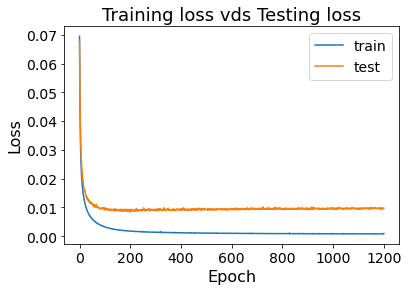

In [37]:
lr = 0.00001
EPOCHS = 6000

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


model.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS),
                optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])


es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = model.fit(x=[train_X, train_future_cov], y=train_y, 
                    epochs=EPOCHS,
                    verbose=2,
                    validation_data=([test_X, test_future_cov], test_y),
                    batch_size = 512,
                    callbacks=[es, mc]
                   )

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vds Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Prediction

In [39]:
from tensorflow.keras.models import load_model

model = load_model('saved_model/rnn_encoder_decoder_24h_pm25_cp1.h5')

In [40]:
y_hat = model.predict([test_X, test_future_cov])

In [42]:
print(y_hat.shape)
print(test_y.shape)
# y_hat = y_hat.reshape((-1, y_hat.shape[1]*y_hat.shape[2]))
# print(y_hat.shape)

(8665, 24)
(8665, 24)


In [43]:
# print(test_y.shape)
# test_y = test_y.reshape((-1, test_y.shape[1]*test_y.shape[2]))
# print(test_y.shape)

In [44]:
inv_yhat = scaler.inverse_transform(y_hat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (8665, 24) (8665, 24)


### Performance

In [45]:
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 33.431
RMSE = 52.448
